In [211]:
# Importar o componente que retornará informarções de uma ação da bolsa de valores
from yahooquery import Ticker
# Componentes de analise
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
from pandas import json_normalize
import pandas as pd
import math


In [63]:
# Vamos fazer uma analise PETR4 (Petrobrás)
petr = Ticker("PETR4.SA")
petr_dados = petr.history(period="max")
petr_dados.index = petr_dados.index.unique(level='date')



In [11]:
petr_dados.head()

volume  close   open    low   high  adjclose  \
symbol   date                                                             
PETR4.SA 2000-01-03  3.538944e+10  5.875  5.875  5.875  5.875  2.139588   
         2000-01-04  2.886144e+10  5.550  5.550  5.550  5.550  2.021228   
         2000-01-05  4.303360e+10  5.494  5.494  5.494  5.494  2.000834   
         2000-01-06  3.405568e+10  5.475  5.475  5.475  5.475  1.993914   
         2000-01-07  2.091264e+10  5.500  5.500  5.500  5.500  2.003019   

                     dividends  splits  
symbol   date                           
PETR4.SA 2000-01-03        0.0     0.0  
         2000-01-04        0.0     0.0  
         2000-01-05        0.0     0.0  
         2000-01-06        0.0     0.0  
         2000-01-07        0.0     0.0

<AxesSubplot: xlabel='date'>

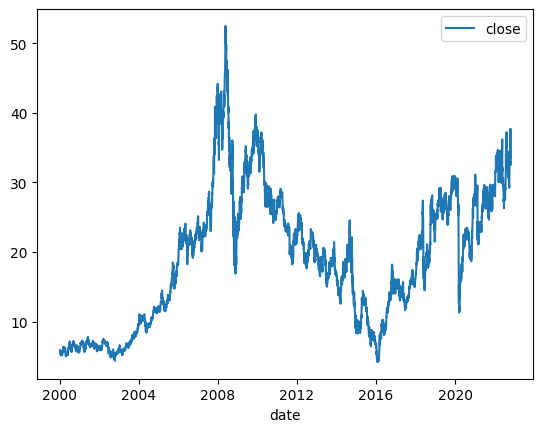

In [68]:
# Verificar a ação desde 2000
petr_dados[["close"]].plot()

C:\Users\gabri\AppData\Local\Temp\ipykernel_79388\1913561827.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()


<AxesSubplot: xlabel='date'>

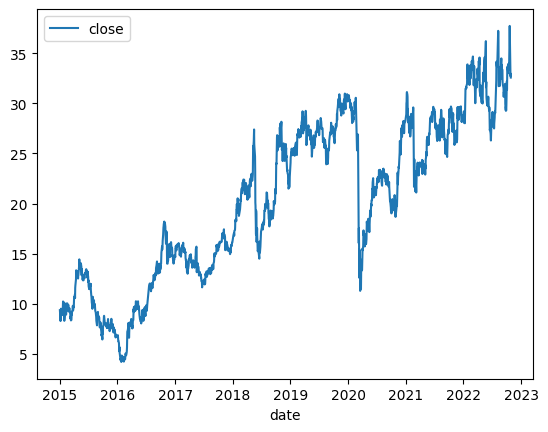

In [73]:
# Verificar a ação a partir 2015
petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()

C:\Users\gabri\AppData\Local\Temp\ipykernel_79388\4124321002.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)


<AxesSubplot: xlabel='date'>

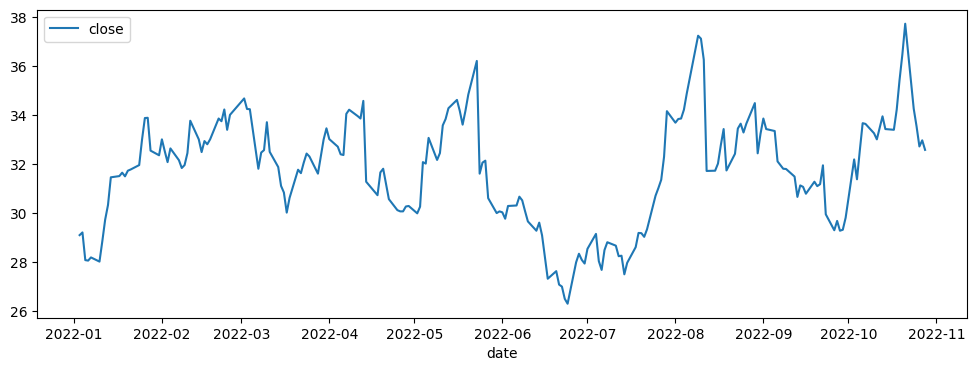

In [75]:
# Verificar a ação esse ano
fig, axs = plt.subplots(figsize=(12, 4))

petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)

C:\Users\gabri\AppData\Local\Temp\ipykernel_79388\2195862388.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]


'----'

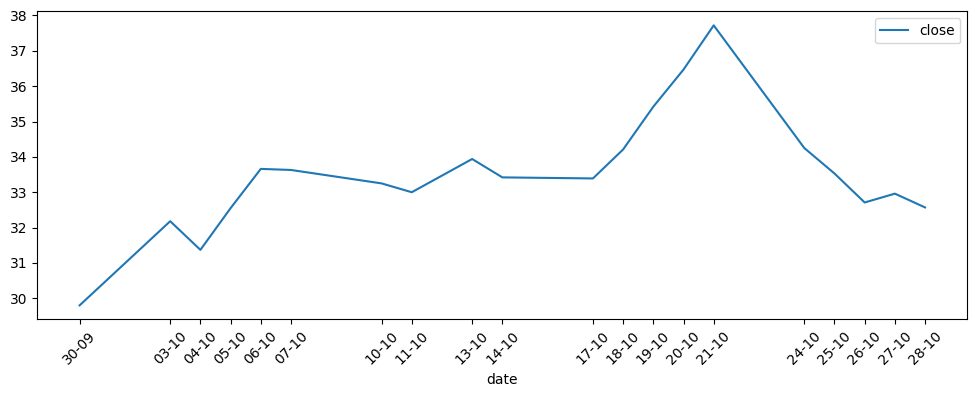

In [119]:
# Verificar o comportamento da ação no ultimo mês

fig, axs = plt.subplots(figsize=(12, 4))
dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]
plot = dados_plot.plot(ax=axs)
x_labels = pd.to_datetime(dados_plot.index).strftime('%d-%m')


plot.set_xticks(dados_plot.index)
plot.set_xticklabels(x_labels, rotation=45)

"----"


In [176]:
# Analisar a base da SELIC

r = requests.get('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json')
retorno_api = r.json()

dt_selic = json_normalize(retorno_api) 
dt_selic



,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9121,24/10/2022,0.050788
9122,25/10/2022,0.050788
9123,26/10/2022,0.050788
9124,27/10/2022,0.050788


In [177]:
# Transformar o retorno da API em uma série, pra se adaptar ao dataset da ação e para que possamos fazer algumas analises 

def converterDataObj(x):
    return datetime.strptime(x, "%d/%m/%Y")
dt_selic["valor"].index = dt_selic["data"].apply(converterDataObj)
dt_selic["valor"].index.names = ['date']

selic = pd.Series(dt_selic["valor"])
#Converter valores pra float

selic = pd.to_numeric(selic)
selic

date
1986-06-04    0.065041
1986-06-05    0.067397
1986-06-06    0.066740
1986-06-09    0.068247
1986-06-10    0.067041
                ...   
2022-10-24    0.050788
2022-10-25    0.050788
2022-10-26    0.050788
2022-10-27    0.050788
2022-10-28    0.050788
Name: valor, Length: 9126, dtype: float64

In [178]:
# Filtrar para apenas nos anos 2000 pra cima, pois é onde se inicia nosso dataset

selic = selic[selic.index >= pd.to_datetime('2000-01-01')]

<AxesSubplot: xlabel='date'>

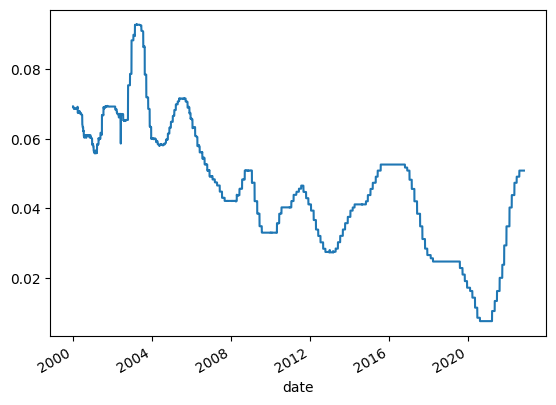

In [179]:
# Verificar o comportamento da SELIC durante os anos 

selic.plot()

In [190]:
# Unir selic com a base PETR4 

petr_dados = petr_dados.assign(selic = selic)

# Verificar se algum ficou em branco 

petr_dados.isna().sum()


volume        0
low           0
close         0
open          0
high          0
adjclose      0
dividends     0
splits        0
selic        62
dtype: int64

In [292]:
# Os em branco vou preencher com o ultimo valor

def preencherUltimoSelic (x):
     
    global selic     
    days = 1   
   
    while math.isnan(x['selic']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in selic.index :
            x['selic'] = selic.loc[atual]                  
        days += 1
    return x


petr_dados[petr_dados["selic"].isna()].apply(preencherUltimoSelic, axis=1)




,volume,low,close,open,high,adjclose,dividends,splits,selic
date,,,,,,,,,
2000-03-06,0.0,6.038,6.038,6.038,6.038,2.198949,0.0,0.0,0.068652
2000-03-07,0.0,6.038,6.038,6.038,6.038,2.198949,0.0,0.0,0.068652
2000-04-21,0.0,5.100,5.100,5.100,5.100,1.857345,0.0,0.0,0.067883
2000-05-01,0.0,5.376,5.376,5.376,5.376,1.957860,0.0,0.0,0.067783
2000-06-22,0.0,6.438,6.438,6.438,6.438,2.344625,0.0,0.0,0.064050
...,...,...,...,...,...,...,...,...,...
2017-09-07,0.0,15.020,15.020,15.020,15.020,7.564652,0.0,0.0,0.034749
2017-10-12,0.0,16.080,16.080,16.080,16.080,8.098510,0.0,0.0,0.031096
2017-11-02,0.0,16.900,16.900,16.900,16.900,8.511492,0.0,0.0,0.028333
